made on 5/nov - not 100% tested, but seems pretty gooood


In [4]:
from math import cos, sin, atan2, acos, sqrt, pi

import cv2

import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

In [5]:
# def inv_kinematics(x,y,z,phi):
#     """ """
#     L1,L2,L3,L4 = 50, 93, 93, 50 # mm
#     r = sqrt(x*x + y*y)
#     s = z - L1 - L4*sin(phi)
#     theta1 = atan2(y,x)
#     theta3 = acos((r*r + s*s - L2*L2 - L3*L3)/(2*L2*L3))
#     print(r*r - s*s)
#     theta2 = atan2(r, s) - atan2(L3*sin(theta3), L2 + L3*cos(theta3))
#     theta4 = phi - theta2 - theta3
    
#     return theta1, theta2, theta3, theta4

In [10]:
# def inv_kinematics(x,y,z,phi):
#     """ """
#     L1,L2,L3,L4 = 50, 93, 93, 50 # mm

#     theta1 = atan2(y, x)

#     A = x - L4*cos(theta1)*cos(phi)
#     B = y - L4*sin(theta1)*cos(phi)
#     C = z - L1 - L4*sin(phi)

#     theta3 = acos((A*A + B*B + C*C - L2*L2 - L3*L3)/(2*L2*L3))
#     a = L3*sin(theta3)
#     b = L2 + L3*cos(theta3)

#     c = z - L1 - L4*sin(phi)
#     r = sqrt(a*a + b*b)

#     theta2 = atan2(c, sqrt(r*r - c*c)) - atan2(a,b)

#     theta4 = phi - theta2 - theta3
    
    # return theta1, theta2, theta3, theta4


def inv_kinematics(x,y,z,phi):
    """ """
    a1,a2,a3,a4 = 50, 93, 93, 50 # mm

    theta1 = atan2(y, x)

    r = sqrt(x*x + y*y)
    r2 = a4 * cos(phi)
    r1 = r - r2

    d1 = a1
    d3 = a4*sin(phi)
    d2 = z - d1 - d3

    C23 = sqrt(r1*r1 + d2*d2)

    # Elbow down
    # theta3 = -acos((a2*a2 + a3*a3 - C23*C23) / (2*a2*a3)) + pi

    # Elbow up - not minus in front of sqrt()
    D = (C23*C23 - a2*a2 - a3*a3) / (-2*a2*a3)
    theta3 = -(atan2(-sqrt(1 - D*D), D) - pi)

    theta2 = atan2(d2, r1) - atan2(a3*sin(theta3), a2+a3*cos(theta3))
    theta4 = phi - theta2 - theta3
    
    return theta1, theta2, theta3, theta4

In [11]:
def forward_kinematics1(t1, t2=None, t3=None, t4=None):
    return np.array([
        [np.cos(t1), 0, np.sin(t1), 0],
        [np.sin(t1), 0, -np.cos(t1), 0],
        [0, 1, 0, 50],
        [0, 0, 0, 1]
    ])

def forward_kinematics2(t1, t2, t3=None, t4=None):
    return np.array([
        [
            (np.cos(t1 - t2) + np.cos(t1 + t2)) / 2,
            (-np.sin(t1 + t2) + np.sin(t1 - t2)) / 2,
            np.sin(t1),
            (93 * np.cos(t1 - t2) + 93 * np.cos(t1 + t2)) / 2
        ],
        [
            (np.sin(t1 + t2) + np.sin(t1 - t2)) / 2,
            (-np.cos(t1 - t2) + np.cos(t1 + t2)) / 2,
            -np.cos(t1),
            (93 * np.sin(t1 + t2) + 93 * np.sin(t1 - t2)) / 2
        ],
        [
            np.sin(t2),
            np.cos(t2),
            0,
            50 + 93 * np.sin(t2)
        ],
        [0, 0, 0, 1]
    ])

def forward_kinematics3(t1, t2, t3, t4=None):
    return np.array([
        [
            (np.cos(-t3 + t1 - t2) + np.cos(t3 + t1 + t2)) / 2,
            (np.sin(-t3 + t1 - t2) - np.sin(t3 + t1 + t2)) / 2,
            np.sin(t1),
            (93 * np.cos(-t3 + t1 - t2) + 93 * np.cos(t3 + t1 + t2)) / 2 +
            (93 * np.cos(t1 - t2) + 93 * np.cos(t1 + t2)) / 2
        ],
        [
            (np.sin(t3 + t1 + t2) + np.sin(-t3 + t1 - t2)) / 2,
            (np.cos(t3 + t1 + t2) - np.cos(-t3 + t1 - t2)) / 2,
            -np.cos(t1),
            (93 * np.sin(t3 + t1 + t2) + 93 * np.sin(-t3 + t1 - t2)) / 2 +
            (93 * np.sin(t1 + t2) + 93 * np.sin(t1 - t2)) / 2
        ],
        [
            np.sin(t2 + t3),
            np.cos(t2 + t3),
            0,
            50 + 93 * np.sin(t2 + t3) + 93 * np.sin(t2)
        ],
        [0, 0, 0, 1]
    ])


def forward_kinematics4(t1, t2, t3, t4):
    """ straight out of chatgpt """
    # Row 1
    r11 = (cos(t4 + t3 + t1 + t2) + cos(-t4 - t3 + t1 - t2)) / 2
    r12 = (-sin(t4 + t3 + t1 + t2) + sin(-t4 - t3 + t1 - t2)) / 2
    r13 = sin(t1)
    r14 = (25 * cos(t4 + t3 + t1 + t2) + 25 * cos(-t4 - t3 + t1 - t2) +
           (93 * cos(-t3 + t1 - t2) + 93 * cos(t3 + t1 + t2) + 
           93 * cos(t1 - t2) + 93 * cos(t1 + t2)) / 2)

    # Row 2
    r21 = (sin(-t4 - t3 + t1 - t2) + sin(t4 + t3 + t1 + t2)) / 2
    r22 = (-cos(-t4 - t3 + t1 - t2) + cos(t4 + t3 + t1 + t2)) / 2
    r23 = -cos(t1)
    r24 = (25 * sin(-t4 - t3 + t1 - t2) + 25 * sin(t4 + t3 + t1 + t2) +
           (93 * sin(t3 + t1 + t2) + 93 * sin(-t3 + t1 - t2) + 
           93 * sin(t1 + t2) + 93 * sin(t1 - t2)) / 2)

    # Row 3
    r31 = sin(t2 + t3 + t4)
    r32 = cos(t2 + t3 + t4)
    r33 = 0
    r34 = 50 + 50 * sin(t2 + t3 + t4) + 93 * sin(t2 + t3) + 93 * sin(t2)

    # Row 4 (last row in homogeneous transformation matrices)
    r41 = 0
    r42 = 0
    r43 = 0
    r44 = 1

    # Assembling the 4x4 matrix as a nested list
    transformation_matrix = [
        [r11, r12, r13, r14],
        [r21, r22, r23, r24],
        [r31, r32, r33, r34],
        [r41, r42, r43, r44]
    ]

    return np.array(transformation_matrix)


In [12]:
# Sanity check
start = (0, 0, 286, pi/2)
end = forward_kinematics4(*inv_kinematics(*start))

# See: https://stackoverflow.com/questions/15262897/how-can-i-get-the-angle-from-a-matrix
angle = acos((np.trace(end) - 1) / 2)

assert np.isclose(end[:3, -1], start[:3]).all(), f"Position is wrong: {end[:3, -1]}"
assert np.isclose(start[-1], angle), f"Angle is wrong: {start[-1]}"

In [13]:
t1, t2, t3, t4 = inv_kinematics(*target)
t1, t2, t3, t4

NameError: name 'target' is not defined

[150. -32. 120.   1.] (150, -32, 120, 0)


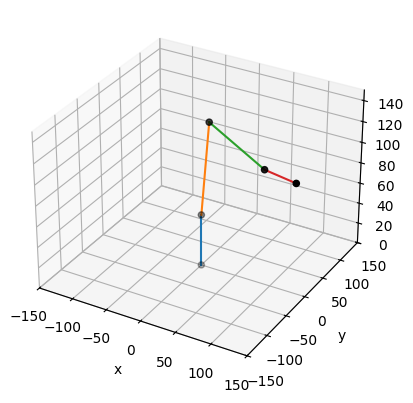

In [14]:
target = (150, -32, 120, 0) # x,y,z,phi # pi/2 points up
t1, t2, t3, t4 = inv_kinematics(*target)

T_0_1 = forward_kinematics1(t1)
T_0_2 = forward_kinematics2(t1, t2)
T_0_3 = forward_kinematics3(t1, t2, t3)
T_0_4 = forward_kinematics4(t1, t2, t3, t4)

origin = np.array([0, 0, 0, 1])
joint1_position = (T_0_1 @ origin)
joint2_position = (T_0_2 @ origin)
joint3_position = (T_0_3 @ origin)
joint4_position = (T_0_4 @ origin)

joint1_position[:3], joint2_position[:3], joint3_position[:3], joint4_position[:3]

joints = np.array([
    origin[:3], joint1_position[:3], joint2_position[:3], joint3_position[:3], joint4_position[:3]
])
joints

ax = plt.figure().add_subplot(projection='3d')
ax.set_xlim(-150, 150)
ax.set_ylim(-150, 150)
ax.set_zlim(0, 150)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

for a, b in zip(joints, joints[1:]):
    ax.plot([a[0], b[0]], [a[1],b[1]],zs=[a[2],b[2]])

ax.scatter(joints[:,0], joints[:,1], zs=joints[:,2], c='black')

# ax.view_init(elev=45, azim=90, roll=0)

print(joint4_position, target)
plt.show()

# Problem 3

[[150.          32.         120.        ]
 [150.          31.5138481  125.55674169]
 [150.          30.07016387 130.94464459]]


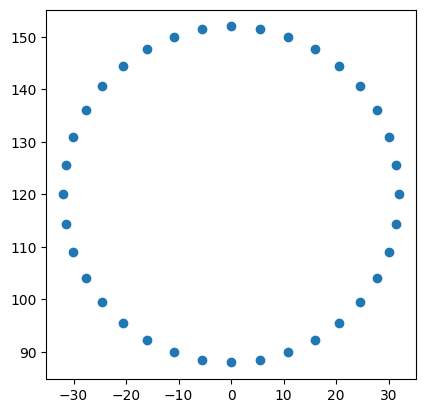

In [15]:
def point_on_circle(phi: float, radius: float = 32):
    centre = np.array([150, 0, 120])
    return centre + radius * np.array([0, cos(phi), sin(phi)])

# around 0 - for testing
# def point_on_circle(phi: float, radius: float = 32):
#     centre = np.array([0, 0, 100])
#     return centre + radius * np.array([cos(phi), sin(phi),0])

ps = [point_on_circle(np.deg2rad(i)) for i in range(0, 360, 10)]
ps = np.array(ps)
print(ps[:3])
plt.scatter(ps[:,1], ps[:,2])
# plt.scatter(ps[:,0], ps[:,1]) # around 0
plt.gca().set_aspect('equal')

plt.show()

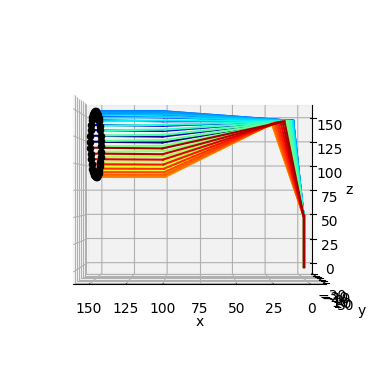

In [16]:
from matplotlib import colors
from matplotlib import cm

# %matplotlib inline

fig = plt.figure(figsize=plt.figaspect(1))
ax = fig.add_subplot(projection='3d')
# ax.set_xlim(-75, 75)
# ax.set_ylim(-75, 75)
# ax.set_zlim(0, 150)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

norm = colors.Normalize(vmin=0, vmax=len(ps))

for i, p in enumerate(ps):
    target = (*p, 0) # x,y,z,phi
    t1, t2, t3, t4 = inv_kinematics(*target)

    T_0_1 = forward_kinematics1(t1)
    T_0_2 = forward_kinematics2(t1, t2)
    T_0_3 = forward_kinematics3(t1, t2, t3)
    T_0_4 = forward_kinematics4(t1, t2, t3, t4)

    origin = np.array([0, 0, 0, 1])
    joint1_position = (T_0_1 @ origin)
    joint2_position = (T_0_2 @ origin)
    joint3_position = (T_0_3 @ origin)
    joint4_position = (T_0_4 @ origin)

    joint1_position[:3], joint2_position[:3], joint3_position[:3], joint4_position[:3]

    joints = np.array([
        origin[:3], joint1_position[:3], joint2_position[:3], joint3_position[:3], joint4_position[:3]
    ])
    colors = ['red', 'green', 'blue', 'orange']
    for a, b in zip(joints, joints[1:]):
        ax.plot([a[0], b[0]], [a[1],b[1]],zs=[a[2],b[2]], c = cm.jet(norm(i)))

    ax.scatter(joints[-1,0], joints[-1,1], zs=joints[-1,2], c='black')

ax.view_init(elev=0, azim=90, roll=0)
# ax.view_init(elev=0, azim=180, roll=0)

plt.show()

In [17]:
np.round([inv_kinematics(*p, 0) for p in ps],4)

array([[ 0.2102,  1.4302,  4.6133, -6.0435],
       [ 0.2071,  1.4437,  4.659 , -6.1027],
       [ 0.1978,  1.4556,  4.7043, -6.1599],
       [ 0.1827,  1.4656,  4.7478, -6.2134],
       [ 0.162 ,  1.4737,  4.788 , -6.2618],
       [ 0.1363,  1.4801,  4.8235, -6.3036],
       [ 0.1063,  1.4848,  4.8528, -6.3376],
       [ 0.0728,  1.488 ,  4.8747, -6.3627],
       [ 0.037 ,  1.4898,  4.8883, -6.3782],
       [ 0.    ,  1.4904,  4.8929, -6.3834],
       [-0.037 ,  1.4898,  4.8883, -6.3782],
       [-0.0728,  1.488 ,  4.8747, -6.3627],
       [-0.1063,  1.4848,  4.8528, -6.3376],
       [-0.1363,  1.4801,  4.8235, -6.3036],
       [-0.162 ,  1.4737,  4.788 , -6.2618],
       [-0.1827,  1.4656,  4.7478, -6.2134],
       [-0.1978,  1.4556,  4.7043, -6.1599],
       [-0.2071,  1.4437,  4.659 , -6.1027],
       [-0.2102,  1.4302,  4.6133, -6.0435],
       [-0.2071,  1.4152,  4.5686, -5.9838],
       [-0.1978,  1.3992,  4.526 , -5.9253],
       [-0.1827,  1.3829,  4.4869, -5.8698],
       [-0

# Problem 4

In [18]:
def jacobian(theta):

    z0 = np.array([0,0,1])
    o0 = np.zeros(3)

    z1 = forward_kinematics1(*inv_kinematics(*point_on_circle(theta), 0))[:3, 2]
    o1 = forward_kinematics1(*inv_kinematics(*point_on_circle(theta), 0))[:3, 3]

    z2 = forward_kinematics2(*inv_kinematics(*point_on_circle(theta), 0))[:3, 2]
    o2 = forward_kinematics2(*inv_kinematics(*point_on_circle(theta), 0))[:3, 3]

    z3 = forward_kinematics3(*inv_kinematics(*point_on_circle(theta), 0))[:3, 2]
    o3 = forward_kinematics3(*inv_kinematics(*point_on_circle(theta), 0))[:3, 3]

    z4 = forward_kinematics4(*inv_kinematics(*point_on_circle(theta), 0))[:3, 2]
    o4 = forward_kinematics4(*inv_kinematics(*point_on_circle(theta), 0))[:3, 3]
    
    J1 = np.vstack([np.cross(z0, (o4 - o0)).reshape(-1,1), z0.reshape(-1,1)])
    J2 = np.vstack([np.cross(z1, (o4 - o1)).reshape(-1,1), z1.reshape(-1,1)])
    J3 = np.vstack([np.cross(z2, (o4 - o2)).reshape(-1,1), z2.reshape(-1,1)])
    J4 = np.vstack([np.cross(z3, (o4 - o3)).reshape(-1,1), z3.reshape(-1,1)])
    
    return np.hstack([J1,J2,J3,J4])

# jacobian(0) * 1/1000
# jacobian(pi/2)
# jacobian(pi)
# jacobian(3*pi / 2)

In [19]:
(jacobian(pi/2) / 1000)[:3]

array([[ 0.        , -0.102     , -0.00930018, -0.        ],
       [ 0.15      , -0.        , -0.        ,  0.        ],
       [ 0.        ,  0.15      ,  0.14253381,  0.05      ]])

In [20]:
np.linalg.lstsq((jacobian(pi/2) / 1000)[:3], np.array([0,-3,0]).reshape(-1,1), rcond=None)


(array([[-20.],
        [  0.],
        [ -0.],
        [ -0.]]),
 array([], dtype=float64),
 np.int32(3),
 array([0.22798756, 0.15      , 0.06187126]))

In [21]:
phi = pi / 2

# Since our robot doesnt have 6 links we cant inverse the matrix
# np.linalg.inv(jacobian(phi))

J = jacobian(phi)

# pseudo inv
J_inv = np.linalg.inv(J.T @ J) @ J.T    # under actuated
# J_inv = J.T @ np.linalg.inv(J @ J.T)    # over actuated


J_inv.shape, np.linalg.matrix_rank(J)

((4, 6), np.int64(4))

In [22]:
J

array([[   0.        , -102.        ,   -9.30018309,   -0.        ],
       [ 150.        ,   -0.        ,   -0.        ,    0.        ],
       [   0.        ,  150.        ,  142.53381325,   50.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ],
       [   0.        ,   -1.        ,   -1.        ,   -1.        ],
       [   1.        ,    0.        ,    0.        ,    0.        ]])

In [23]:
R = forward_kinematics4(*inv_kinematics(*point_on_circle(phi), 0))[:3, :3]


v = np.array([0, -3, 0])
w = cv2.Rodrigues(R)[0].flatten() # WRONG


xi = np.hstack([v,w])

np.linalg.lstsq(J_inv.T, xi, rcond=None)[0]

array([-450.,   -0.,   -0.,    0.])

In [24]:
R

array([[ 1.,  0.,  0.],
       [ 0.,  0., -1.],
       [ 0.,  1.,  0.]])

In [25]:
def temporal_rate(R, w) -> np.ndarray:
    x_dot = np.array([
        [R[2,0] * w[1] - R[1,0] * w[2], R[2,1] * w[1] - R[1,1] * w[2], R[2,2] * w[1] - R[1,2] * w[2]],
        [R[0,0] * w[2] - R[2,0] * w[0], R[0,1] * w[2] - R[2,1] * w[0], R[0,2] * w[2] - R[2,2] * w[0]],
        [R[1,0] * w[0] - R[0,0] * w[1], R[1,1] * w[0] - R[0,1] * w[1], R[1,2] * w[0] - R[0,2] * w[1]],
    ])
    return x_dot

In [26]:
R, R[1,2], w

temporal_rate(R, w)

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        , -1.57079633,  0.        ],
       [-0.        ,  0.        , -1.57079633]])

In [29]:
temporal_rate(R, w)

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        , -1.57079633,  0.        ],
       [-0.        ,  0.        , -1.57079633]])

In [35]:
_w = np.array([0, 0, -0.02])
temporal_rate(R, _w)

array([[ 0.  ,  0.  , -0.02],
       [-0.02, -0.  , -0.  ],
       [ 0.  ,  0.  , -0.  ]])

# Problem 5

In [ ]:
point_on_circle(pi/2)

array([150.,   0., 152.])